<a href="https://colab.research.google.com/github/dieguito1331/cienciaDatos/blob/master/maestria/teoria/09 - Multi layer perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Perceptron multicapa

![imagen](https://i.ytimg.com/vi/Fz4Uo8_uUfg/hqdefault.jpg)

Los perceptrones multicapa posee como mínimo tres capas de neuronas:
* La capa de entrada (la cantidad de neuronas dependerá de las variables de entrada)
* Capa de salida (la cantidad de neuronas dependerá de la cantidad de salidas que vayamos a tener)
* Capas ocultas: En las capas ocultas se realiza todo el procesamiento. A medida que agregamos más capas ocultas, la complejidad de la red aumenta.

Si un perceptrón posee una única capa oculta, se llamará _shallow neural network_ (red neuronal poco profunda)
Si un perceptrón posee más de una capa oculta se llamará _deep neural networks_ (redes neuronales profundas)

Cada neurona poseerá un peso. Por tal motivo, las operaciones matemáticas que se generarán en la red será multiplicaciones matriciales.

Para poder trabajar con un perceptron multicapa se debe definir lo siguiente:
* Cantidad de capas ocultas
* Cantidad de neuronas por capa oculta
* Función de activación
* Función de pérdida
* Algoritmo de backpropagation

No siempre es mejor usar una red compleja. En general mientras más compleja sea la red, más tiempo tardará el proceso de entrenamiento y pueden surgir problemas de overfitting. Por otro lado, mientras menos compleja es una red menos capacidad tendrá de distinguir relaciones no lineales entre las entradas y las salidas.


**Definimos los pesos de la red neuronal**

$$\mathbf{W} = \left[\begin{array}
{rr}
w_{1,1} & w_{1,2} \\
w_{2,1} & w_{2,2}  \\
w_{3,1} & w_{3,2} 
\end{array}\right]
$$

Cada una de las filas se relacionan con las entradas y las columnas con los nodos intermedios. Las entradas son del tipo:

$$\mathbf{X} = \left[\begin{array}
{rrr}
x_{1} & x_{2} & x_{3}
\end{array}\right]
$$


En nuestro ejemplo pasaremos tendremos una matriz de 4x3 y una segunda matriz de 3x2


Una función de activación puede ser la **sigmoide**
$$\sigma(x) = \frac{1}{1+e^{-x}}$$

Otra función puede ser la función **ReLu** (Rectified Linear Units). Cualquier valor menor a 0 la función lo convierte en 0, sino el valor de entrada es el valor de salida.

$$f(X) = max(0,X)$$

In [1]:
import os
from google.colab import drive
import pandas as pd
from sklearn.model_selection import train_test_split##
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.neural_network import MLPClassifier



#Levanto drive para poder almacenar los archivos
drive.mount("/content/drive")
contentFolder = "/content/drive/MyDrive/Austral - Data Mining"
if not os.path.exists(contentFolder):
    os.mkdir(contentFolder)

Mounted at /content/drive


In [2]:
data = pd.read_csv("{}/titanicPreprocesada.txt".format(contentFolder), sep=";")

In [3]:
X = data.drop(columns = ["index", "Survived"])
y = data.Survived
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train = X_train.values.astype(np.float32, order="C")
X_test = X_test.values.astype(np.float32, order="C")
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)


Y_train = Y_train.values
Y_test = Y_test.values




### Modelo hecho a mano

In [137]:

# Define the sigmoid activator; we ask if we want the sigmoid or its derivative
def sigmoid_act(x, der=False):
    import numpy as np
    
    if (der==True) : #derivative of the sigmoid
        f = 1/(1+ np.exp(- x))*(1-1/(1+ np.exp(- x)))
    else : # sigmoid
        f = 1/(1+ np.exp(- x))
    
    return f

# We may employ the Rectifier Linear Unit (ReLU)
def ReLU_act(x, der=False):
    import numpy as np
    
    if (der == True): # the derivative of the ReLU is the Heaviside Theta
        f = np.heaviside(x, 1)
    else :
        f = np.maximum(x, 0)
    
    return f

In [161]:
# Set up the number of perceptron per each layer:
p=4 # Layer 1
q=4 # Layer 2

# Set up the Learning rate
eta =  1/623


# 0: Random initialize the relevant data 
w1 = 2*np.random.rand(p , X_train.shape[1]) - 0.5 # Layer 1
b1 = np.random.rand(p)

w2 = 2*np.random.rand(q , p) - 0.5  # Layer 2
b2 = np.random.rand(q)

wOut = 2*np.random.rand(q) - 0.5  # Output Layer
bOut = np.random.rand(1)

mu = []
vec_y = []

# Start looping over the passengers, i.e. over I.

for I in range(0, X_train.shape[0]): #loop in all the passengers:
    
    # 1: input the data 
    x = X_train[I]
    
    
    # 2: Start the algorithm
    
    # 2.1: Feed forward
    z1 = ReLU_act(np.dot(w1, x) + b1) # output layer 1 
    z2 = ReLU_act(np.dot(w2, z1) + b2) # output layer 2
    y = sigmoid_act(np.dot(wOut, z2) + bOut) # Output of the Output layer
    
    #2.2: Compute the output layer's error
    delta_Out =  (y-Y_train[I]) * sigmoid_act(y, der=True)
    
    #2.3: Backpropagate
    delta_2 = delta_Out * wOut * ReLU_act(z2, der=True) # Second Layer Error
    delta_1 = np.dot(delta_2, w2) * ReLU_act(z1, der=True) # First Layer Error
    
    # 3: Gradient descent 
    wOut = wOut - eta*delta_Out*z2  # Outer Layer
    bOut = bOut - eta*delta_Out
    
    w2 = w2 - eta*np.kron(delta_2, z1).reshape(q,p) # Hidden Layer 2
    b2 = b2 - eta*delta_2
    
    w1 = w1 - eta*np.kron(delta_1, x).reshape(p, x.shape[0]) # Hidden Layer 1
    b1 = b1 - eta*delta_1
    
    # 4. Computation of the loss function
    mu.append((1/2)*(y-Y_train[I])**2)
    vec_y.append(y[0])


In [190]:
def ANN_train(X_train, Y_train, p=4, q=4, eta=0.0015):
    
    # 0: Random initialize the relevant data 
    w1 = 2*np.random.rand(p , X_train.shape[1]) - 0.5 # Layer 1
    b1 = np.random.rand(p)

    w2 = 2*np.random.rand(q , p) - 0.5  # Layer 2
    b2 = np.random.rand(q)

    wOut = 2*np.random.rand(q) - 0.5   # Output Layer
    bOut = np.random.rand(1)

    mu = []
    vec_y = []

    # Start looping over the passengers, i.e. over I.

    for I in range(0, X_train.shape[0]-1): #loop in all the passengers:
    
        # 1: input the data 
        x = X_train[I]
    
        # 2: Start the algorithm
    
        # 2.1: Feed forward
        z1 = ReLU_act(np.dot(w1, x) + b1) # output layer 1 
        z2 = ReLU_act(np.dot(w2, z1) + b2) # output layer 2
        y = sigmoid_act(np.dot(wOut, z2) + bOut) # Output of the Output layer
    
        #2.2: Compute the output layer's error
        delta_Out = 2 * (y-Y_train[I]) * sigmoid_act(y, der=True)
    
        #2.3: Backpropagate
        delta_2 = delta_Out * wOut * ReLU_act(z2, der=True) # Second Layer Error
        delta_1 = np.dot(delta_2, w2) * ReLU_act(z1, der=True) # First Layer Error
    
        # 3: Gradient descent 
        wOut = wOut - eta*delta_Out*z2  # Outer Layer
        bOut = bOut - eta*delta_Out
    
        w2 = w2 - eta*np.kron(delta_2, z1).reshape(q,p) # Hidden Layer 2
        b2 = b2 -  eta*delta_2
    
        w1 = w1 - eta*np.kron(delta_1, x).reshape(p, x.shape[0])
        b1 = b1 - eta*delta_1
    
        # 4. Computation of the loss function
        mu.append((y-Y_train[I])**2)
        vec_y.append(y)
    
    batch_loss = []
    for i in range(0, 9):
        loss_avg = 0
        for m in range(0, 59):
            loss_avg+=vec_y[60*i+m]/60
        batch_loss.append(loss_avg)
    
    
    plt.figure(figsize=(10,6))
    plt.scatter(np.arange(1, len(batch_loss)+1), batch_loss, alpha=1, s=10, label='error')
    plt.title('Averege Loss by epoch', fontsize=20)
    plt.xlabel('Epoch', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.show()
    
    return w1, b1, w2, b2, wOut, bOut, mu

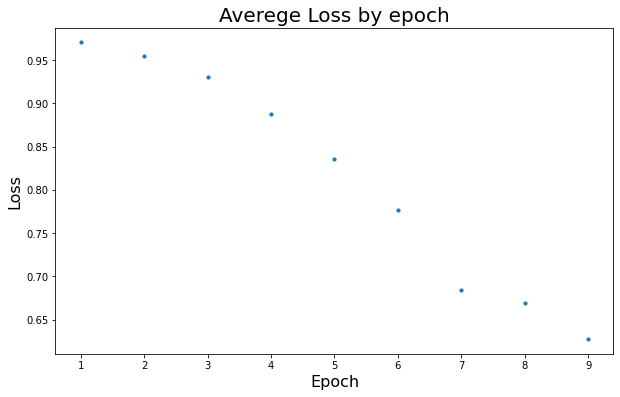

In [191]:
w1, b1, w2, b2, wOut, bOut, mu = ANN_train(X_train, Y_train, p=8, q=4, eta=0.0015)


In [192]:
def ANN_pred(X_test, w1, b1, w2, b2, wOut, bOut, mu):
    import numpy as np
    
    pred = []
    
    for I in range(0, X_test.shape[0]): #loop in all the passengers
        # 1: input the data 
        x = X_test[I]
        
        # 2.1: Feed forward
        z1 = ReLU_act(np.dot(w1, x) + b1) # output layer 1 
        z2 = ReLU_act(np.dot(w2, z1) + b2) # output layer 2
        y = sigmoid_act(np.dot(wOut, z2) + bOut)  # Output of the Output layer
        
        # Append the prediction;
        # We now need a binary classifier; we this apply an Heaviside Theta and we set to 0.5 the threshold
        # if y < 0.5 the output is zero, otherwise is 1
        pred.append( np.heaviside(y - 0.5, 1)[0] )
    
    
    return np.array(pred)

In [201]:
def ANN_pred_proba(X_test, w1, b1, w2, b2, wOut, bOut, mu):
    import numpy as np
    
    pred = []
    
    for I in range(0, X_test.shape[0]): #loop in all the passengers
        # 1: input the data 
        x = X_test[I]
        
        # 2.1: Feed forward
        z1 = ReLU_act(np.dot(w1, x) + b1) # output layer 1 
        z2 = ReLU_act(np.dot(w2, z1) + b2) # output layer 2
        y = sigmoid_act(np.dot(wOut, z2) + bOut)  # Output of the Output layer
        
        # Append the prediction;
        # We now need a binary classifier; we this apply an Heaviside Theta and we set to 0.5 the threshold
        # if y < 0.5 the output is zero, otherwise is 1
        pred.append( y)
    
    
    return np.array(pred)

In [202]:
predictions = ANN_pred(X_test, w1, b1, w2, b2, wOut, bOut, mu)
preds = ANN_pred_proba(X_test, w1, b1, w2, b2, wOut, bOut, mu)

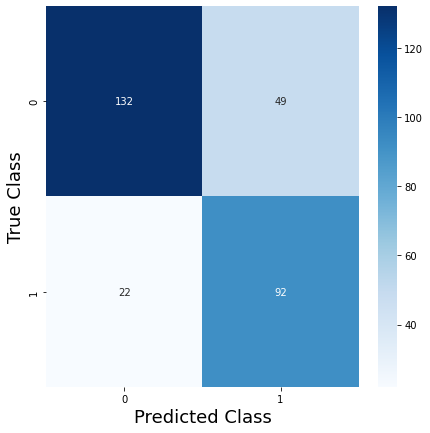

In [199]:
# Plot the confusion matrix
cm = confusion_matrix(Y_test, predictions)

plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, fmt='g')
plt.xlabel("Predicted Class", fontsize=18)
plt.ylabel("True Class", fontsize=18)
plt.show()

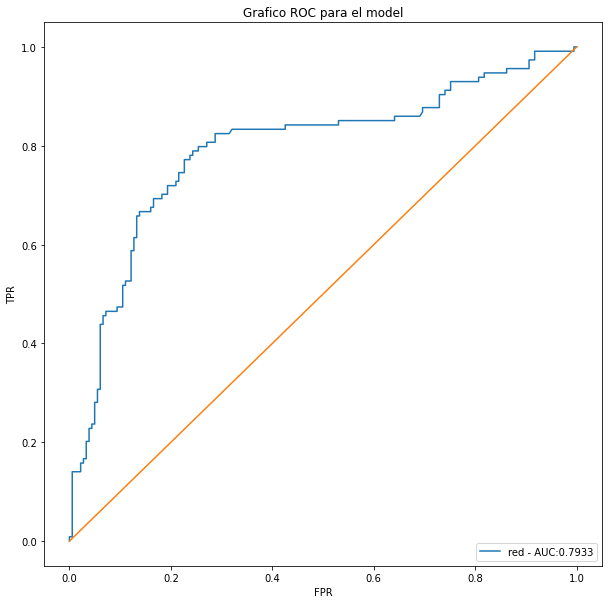

In [208]:
#De esta forma graficamos la curva ROC y calculamos el área debajo de la curva
plt.figure(figsize=(10,10))
plt.title("Grafico ROC para el model")


areaBajoCurva = roc_auc_score(Y_test, preds)
fpr, tpr, _ = roc_curve(Y_test, preds)
plt.plot(fpr, tpr, label="{} - AUC:{}".format("red", round(areaBajoCurva,4)))


plt.legend(loc="lower right")
plt.plot([0,1])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

### Modelo en scikit-learn

Vamos a crear un modelo un poco más complejo ya que agregaremos dos capas ocultas (Trabajaremos con deep learning)

In [4]:
#Initializing the MLPClassifier
classifier = MLPClassifier(hidden_layer_sizes=(16,12), max_iter=300,activation = 'relu',solver='adam',random_state=1)
classifier.fit(X_train, Y_train)


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


MLPClassifier(hidden_layer_sizes=(16, 12), max_iter=300, random_state=1)

In [5]:
y_pred = classifier.predict(X_test)
y_probas = classifier.predict_proba(X_test)[:,-1]


In [6]:
accuracy_score(Y_test, y_pred)

0.8101694915254237

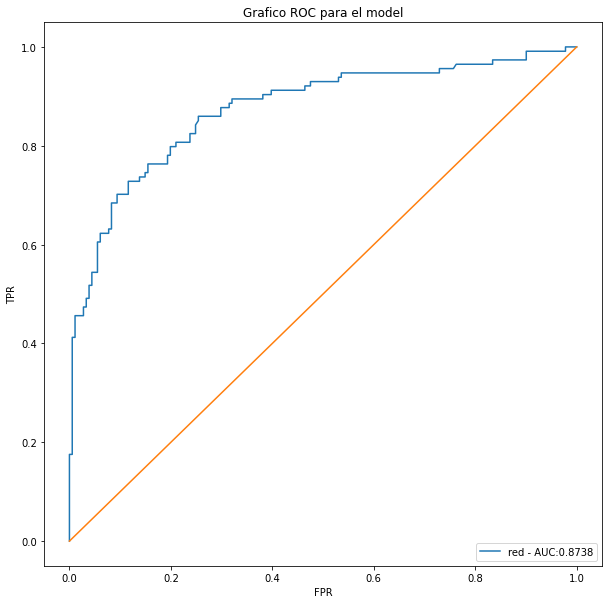

In [7]:
#De esta forma graficamos la curva ROC y calculamos el área debajo de la curva
plt.figure(figsize=(10,10))
plt.title("Grafico ROC para el model")


areaBajoCurva = roc_auc_score(Y_test, y_probas)
fpr, tpr, _ = roc_curve(Y_test, y_probas)
plt.plot(fpr, tpr, label="{} - AUC:{}".format("red", round(areaBajoCurva,4)))


plt.legend(loc="lower right")
plt.plot([0,1])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

### Modelo en Keras

In [15]:
#Dependencies
import keras
from keras.models import Sequential
from keras.layers import Dense
# Neural network
model = Sequential()
model.add(Dense(16, input_dim=9, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [38]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])

In [39]:
history = model.fit(X_train, Y_train, epochs=100)


Epoch 1/100
19/19 [==============================] - 1s 2ms/step - loss: 0.2509 - auc: 0.9523
Epoch 2/100
19/19 [==============================] - 0s 2ms/step - loss: 0.2432 - auc: 0.9567
Epoch 3/100
19/19 [==============================] - 0s 2ms/step - loss: 0.2443 - auc: 0.9545
Epoch 4/100
19/19 [==============================] - 0s 2ms/step - loss: 0.2422 - auc: 0.9559
Epoch 5/100
19/19 [==============================] - 0s 2ms/step - loss: 0.2416 - auc: 0.9566
Epoch 6/100
19/19 [==============================] - 0s 2ms/step - loss: 0.2415 - auc: 0.9578
Epoch 7/100
19/19 [==============================] - 0s 4ms/step - loss: 0.2408 - auc: 0.9558
Epoch 8/100
19/19 [==============================] - 0s 3ms/step - loss: 0.2424 - auc: 0.9550
Epoch 9/100
19/19 [==============================] - 0s 2ms/step - loss: 0.2424 - auc: 0.9554
Epoch 10/100
19/19 [==============================] - 0s 1ms/step - loss: 0.2429 - auc: 0.9560
Epoch 11/100
19/19 [==============================] - 0s 1m

In [40]:
y_pred = model.predict(X_test)


In [41]:
from sklearn.metrics import accuracy_score
a = accuracy_score(y_pred > 0.5,Y_test)
print('Accuracy is:', a*100)

Accuracy is: 76.61016949152543


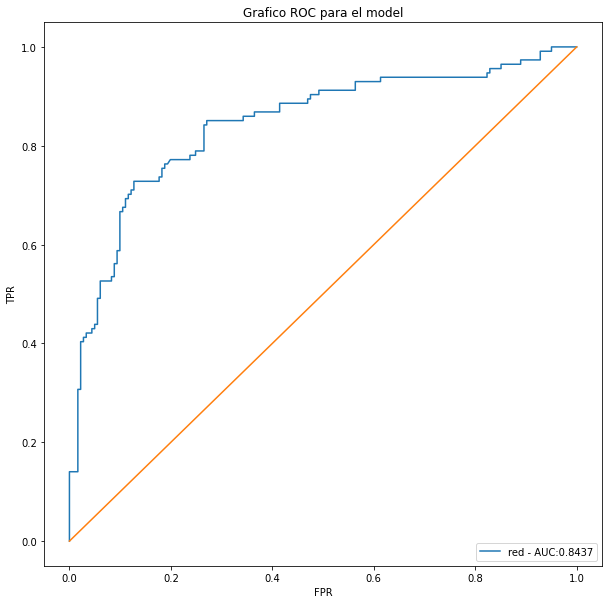

In [42]:
#De esta forma graficamos la curva ROC y calculamos el área debajo de la curva
plt.figure(figsize=(10,10))
plt.title("Grafico ROC para el model")


areaBajoCurva = roc_auc_score(Y_test, y_pred)
fpr, tpr, _ = roc_curve(Y_test, y_pred)
plt.plot(fpr, tpr, label="{} - AUC:{}".format("red", round(areaBajoCurva,4)))


plt.legend(loc="lower right")
plt.plot([0,1])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [43]:
history = model.fit(X_train, Y_train,validation_data = (X_test,Y_test), epochs=100)

Epoch 1/100
19/19 [==============================] - 0s 12ms/step - loss: 0.2404 - auc: 0.9572 - val_loss: 0.6908 - val_auc: 0.8447
Epoch 2/100
19/19 [==============================] - 0s 3ms/step - loss: 0.2402 - auc: 0.9570 - val_loss: 0.6957 - val_auc: 0.8415
Epoch 3/100
19/19 [==============================] - 0s 3ms/step - loss: 0.2407 - auc: 0.9570 - val_loss: 0.7090 - val_auc: 0.8464
Epoch 4/100
19/19 [==============================] - 0s 2ms/step - loss: 0.2382 - auc: 0.9580 - val_loss: 0.6968 - val_auc: 0.8437
Epoch 5/100
19/19 [==============================] - 0s 3ms/step - loss: 0.2399 - auc: 0.9555 - val_loss: 0.6995 - val_auc: 0.8425
Epoch 6/100
19/19 [==============================] - 0s 3ms/step - loss: 0.2386 - auc: 0.9593 - val_loss: 0.6947 - val_auc: 0.8423
Epoch 7/100
19/19 [==============================] - 0s 3ms/step - loss: 0.2400 - auc: 0.9575 - val_loss: 0.7088 - val_auc: 0.8433
Epoch 8/100
19/19 [==============================] - 0s 3ms/step - loss: 0.2445 - 

In [45]:
history.history.keys()

dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])

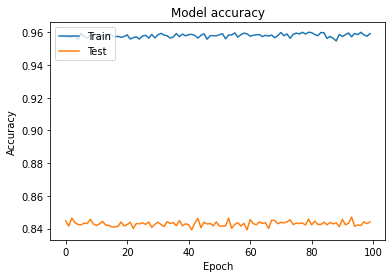

In [46]:
import matplotlib.pyplot as plt
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

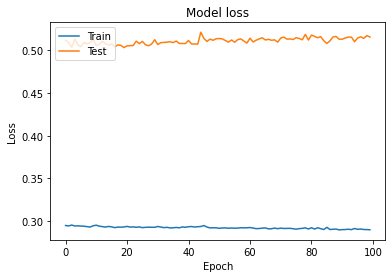

In [35]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()